In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
shots_psa = pd.read_csv('./assets/mpd/shots_train_preprocessed.csv', index_col='ID')

In [9]:
shots_psa.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28343 entries, 5D39700 to 6D200900
Data columns (total 6 columns):
Type         28343 non-null object
Date         28343 non-null object
Time         28343 non-null object
Source       28343 non-null object
Latitude     28343 non-null float64
Longitude    28343 non-null float64
dtypes: float64(2), object(4)
memory usage: 1.5+ MB


In [10]:
shots_psa.head()

,Type,Date,Time,Source,Latitude,Longitude
ID,,,,,,
5D39700,Multiple_Gunshots,2014-01-01,00:00:02,5D,38.917,-77.012
5D39701,Multiple_Gunshots,2014-01-01,00:00:06,5D,38.917,-77.002
5D39702,Multiple_Gunshots,2014-01-01,00:00:07,5D,38.917,-76.987
7D119445,Multiple_Gunshots,2014-01-01,00:00:10,7D,38.823,-77.000
1D55993,Multiple_Gunshots,2014-01-01,00:00:10,1D,38.893,-76.993


In [11]:
geometry = [Point(xy) for xy in zip(shots_psa['Longitude'], shots_psa['Latitude'])]
shots_psa.drop(['Longitude', 'Latitude'], axis=1, inplace=True)
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(shots_psa, geometry=geometry, crs=crs)

In [12]:
psa = gpd.read_file('./assets/Police_Service_Areas.geojson')

In [13]:
psa = psa[['PSA','geometry']]

In [14]:
psa.PSA.nunique()

56

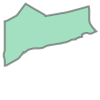

In [15]:
psa['geometry'][2]

In [16]:
shots_psa = gpd.sjoin(gdf, psa, how='left', op='within')

In [17]:
# Setting up the dataframe to have only the key features.  Keeping type, Date, PSA and index to keep it unique
shots_psa.reset_index(inplace=True)
shots_psa.drop(['geometry', 'Source', 'Time', 'index_right'], axis=1, inplace=True)
shots_psa.set_index('index', inplace=True)

In [18]:
# After a lot of review, the null values are not in Washington DC so we will drop them.
shots_psa.PSA.isnull().sum()

907

In [19]:
shots_psa.dropna(inplace=True)
shots_psa.PSA = shots_psa.PSA.astype(int)

# Only 48 of the 56 PSA are within the shots fired.  
print(shots_psa.PSA.nunique())
shots_psa.head()

48


,Type,Date,PSA
index,,,
5D39700,Multiple_Gunshots,2014-01-01,501
5D39701,Multiple_Gunshots,2014-01-01,502
5D39702,Multiple_Gunshots,2014-01-01,505
7D119445,Multiple_Gunshots,2014-01-01,708
1D55993,Multiple_Gunshots,2014-01-01,107


In [20]:
# shots_psa.to_csv('./assets/mpd/shots_train_psa.csv')

In [143]:
shots_psa = pd.read_csv('./assets/mpd/shots_train_psa.csv')
homes = pd.read_csv('./assets/housing_data_psa.csv', index_col='Unnamed: 0')

In [154]:
shots_psa.shape, homes.shape

((27436, 4), (2644, 8))

In [144]:
shots_psa.PSA = shots_psa.PSA.astype(str)
shots_psa = pd.get_dummies(shots_psa, columns=['Type'], drop_first=True)
shots_psa.Date = pd.to_datetime(shots_psa.Date)
shots_psa.drop('index', axis=1, inplace=True)

shots_psa.head()

,Date,PSA,Type_Multiple_Gunshots,Type_Single_Gunshot
0,2014-01-01,501,1,0
1,2014-01-01,502,1,0
2,2014-01-01,505,1,0
3,2014-01-01,708,1,0
4,2014-01-01,107,1,0


In [145]:
def lower_columns(df):
    df.columns = map(str.lower, df.columns)
    return df

shots_psa = lower_columns(shots_psa)
homes = lower_columns(homes)

In [146]:
def district(df):
    df['district'] = df.psa.map(lambda x: str(x)[0])
    df.drop('psa', axis=1, inplace=True)
    return df

shots_district = district(shots_psa)
homes_district = district(homes)

In [147]:
homes_district = homes_district.groupby(['district']) \
    ['median_sale_price', 'homes_sold', 'homes_sold_mom', 
     'days_on_market', 'average_sale_to_list_mom'].agg('mean')

In [148]:
homes_district = homes_district.reset_index()

In [149]:
# This information was found using zillow's data.
district_7_median = np.median((315, 311.4, 311.3, 309.7, 296.5, 270.7, 266.8, 197.6)) * 0.933 **2
district_7_h_sold = np.mean(homes_district.homes_sold)
district_7_h_mom = np.mean(homes_district.homes_sold_mom)
district_7_h_days = np.mean(homes_district.days_on_market)
district_7 = {'district': '7', 
              'median_sale_price': district_7_median, 
              'homes_sold': district_7_h_sold, 
              'homes_sold_mom': district_7_h_mom, 
              'days_on_market': district_7_h_days, 
              'average_sale_to_list_mom': 0}

homes_district = homes_district.append(district_7, ignore_index=True)

In [150]:
# homes_district.to_pickle('./assets/homes_district.pkl')

In [151]:
shots_price = pd.merge(shots_district, homes_district, how='left', left_on=('district'), right_on=('district'))

In [153]:
shots_price.shape

(27436, 9)